In [1]:
import sys
sys.path.append('../')

from quantumsim import *
from pennylane import numpy as np
import matplotlib.pyplot as plt



def molecular_energies(symbols, coordinates, basis_set, charge=0):
    multiplicity = 1
    # Generate the molecular Hamiltonian
    hamiltonian = qml.qchem.molecular_hamiltonian(
        symbols = symbols,
        coordinates = coordinates,
        basis=basis_set,
        charge=charge,
        mult=multiplicity
    )[0]

    # Obtain the matrix representation of the Hamiltonian
    ee = qml.eigvals(hamiltonian)
    return np.sort(ee)

# Analisis de hiperparametros

## Moleculas (dimeros)

In [2]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
}

#Construccion de la clase
molecule1 = vqe_molecular(symbols, coordinates, params)
molecule1.set_group_characteristics()

symbols = ["He", "He"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 98.265751406], requires_grad=True)
params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
}

#Construccion de la clase
molecule2 = vqe_molecular(symbols, coordinates, params)
molecule2.set_group_characteristics()
print(molecule1.qubits, molecule2.qubits)

4 4


In [3]:
symbols = ["Li", "Li"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 5.1646211268], requires_grad=True)
params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
}

#Construccion de la clase
molecule3 = vqe_molecular(symbols, coordinates, params)
molecule3.set_group_characteristics()

symbols = ["Be", "Be"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 4.5], requires_grad=True)
params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
}

#Construccion de la clase
molecule4 = vqe_molecular(symbols, coordinates, params)
molecule4.set_group_characteristics()

print(molecule3.qubits, molecule4.qubits)


20 20


## Hydrogen dimer

#### KUPCCGSD Ansatz

Numero de electrones igual a la cantidad de electrones de valencia

In [5]:
valores = []
for k in range(4):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": molecule1.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=molecule1.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    molecule1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule1.cost_function)
    valores.append(energy1)

/Users/simulations/miniconda3/envs/quantum-computing/lib/python3.10/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


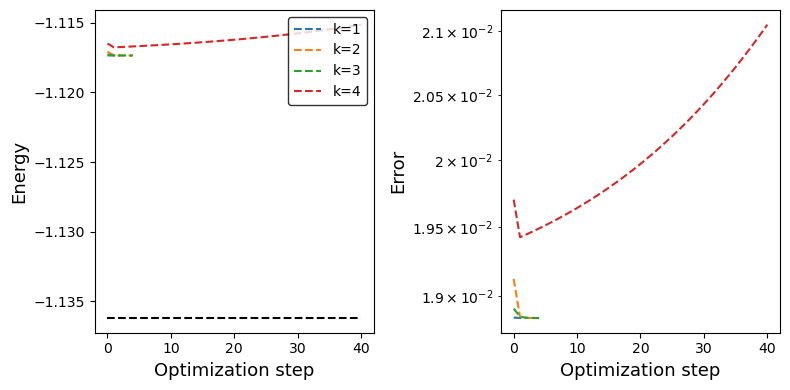

In [6]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"])

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

#### UCCDS Ansatz

Numero de electrones igual a la cantidad de electrones de valencia

In [7]:
valores = []
for k in range(1):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": molecule1.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    molecule1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule1.cost_function)
    valores.append(energy1)

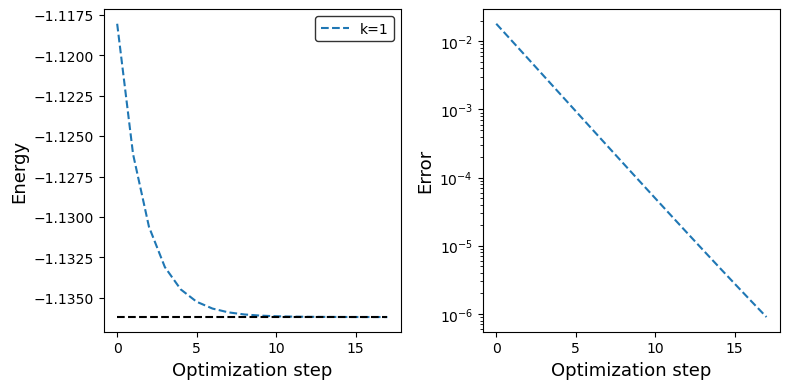

In [8]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"])

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

#### HE Ansatz

Numero de electrones igual a la cantidad de electrones de valencia

In [10]:
valores = []
for k in range(4):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": molecule1.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = he_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number": molecule1.qubits*ansatz_params["repetitions"],
            "theta":["generic", 0.3]}

    molecule1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule1.cost_function)
    valores.append(energy1)

/Users/simulations/miniconda3/envs/quantum-computing/lib/python3.10/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


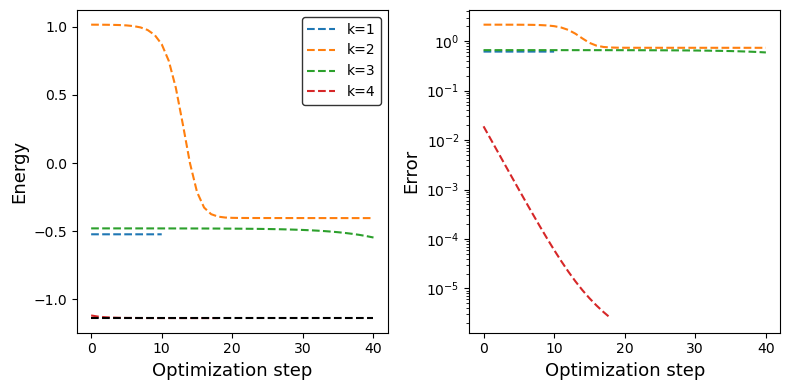

In [11]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"])

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

## Helium dimer

#### KUPCCGSD Ansatz

Numero de electrones igual a la cantidad de electrones de valencia

In [12]:
valores = []
for k in range(4):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 4,
        "qubits": molecule2.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=molecule2.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 1e-6,
            "number": a*b,
            "theta":["generic", 0.3]}

    molecule2.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule2.cost_function)
    valores.append(energy1)

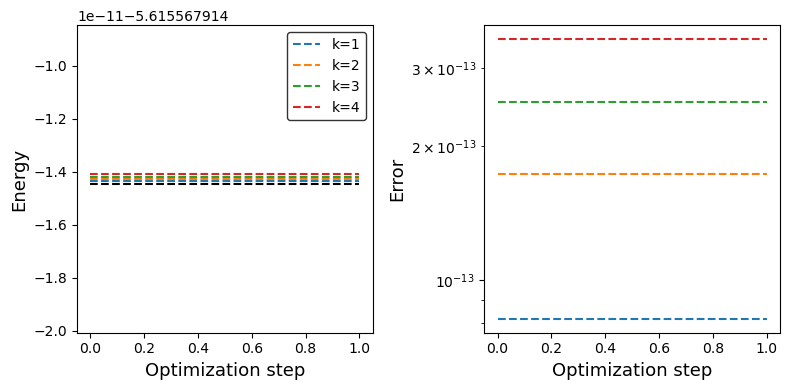

In [14]:
symbols = ["He", "He"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 98.265751406], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=0)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

#### UCCDS Ansatz

Numero de electrones igual a la cantidad de electrones de valencia/2

In [16]:
valores = []
for k in range(1):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": molecule2.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    molecule2.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule2.cost_function)
    valores.append(energy1)

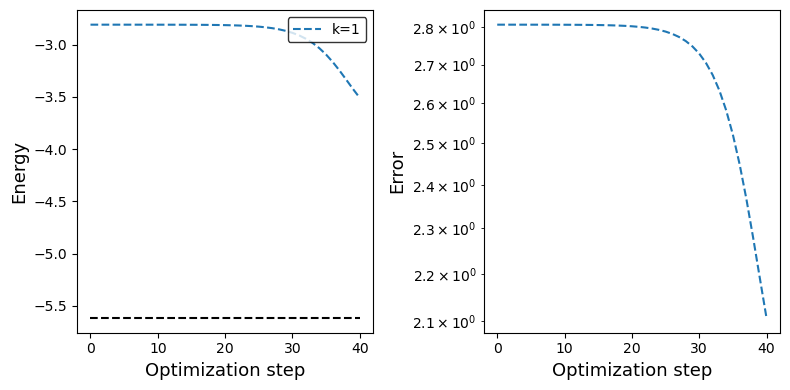

In [17]:
symbols = ["He", "He"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 98.265751406], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=0)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

#### HE Ansatz

In [18]:
valores = []
for k in range(4):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 4,
        "qubits": molecule2.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = he_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number": molecule2.qubits*ansatz_params["repetitions"],
            "theta":["generic", 0.3]}

    molecule2.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule2.cost_function)
    valores.append(energy1)

/Users/simulations/miniconda3/envs/quantum-computing/lib/python3.10/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


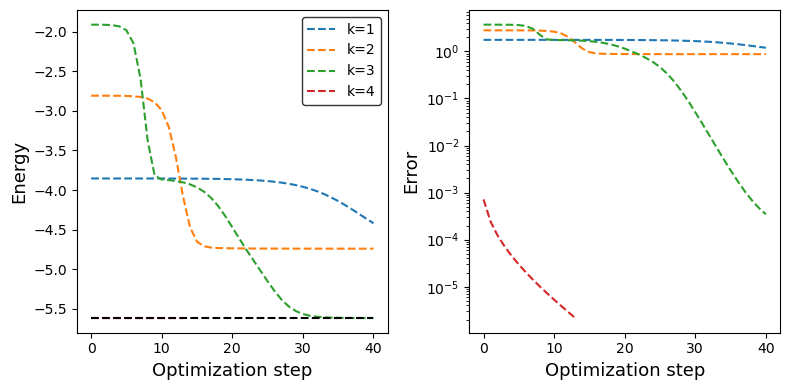

In [19]:
symbols = ["He", "He"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 98.265751406], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=0)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

## Lithium dimer

#### KUPCCGSD Ansatz

In [4]:
valores = []
for k in range(4):
    print(k+1)
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 6,
        "qubits": molecule3.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=molecule3.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    molecule3.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule3.cost_function)
    valores.append(energy1)

1


KeyboardInterrupt: 

In [5]:
symbols = ["Li", "Li"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 5.1646211268], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=0)


fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

KeyboardInterrupt: 

#### UCCDS Ansatz

In [7]:
valores = []
for k in range(1):
    print(k+1)
    ansatz_params = {
        "repetitions": k+1,
        "base": "lightning.qubit",
        "interface": "autograd",
        "electrons": 6,
        "qubits": molecule3.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    molecule3.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule3.cost_function)
    valores.append(energy1)

1


KeyboardInterrupt: 

In [ ]:
#symbols = ["Li", "Li"]
#coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 5.1646211268], requires_grad=True)
#ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=0)


fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
#    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
#ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

#### HE Ansatz

In [ ]:
valores = []
for k in range(4):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 4,
        "qubits": molecule3.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = he_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number": molecule3.qubits*ansatz_params["repetitions"],
            "theta":["generic", 0.3]}

    molecule2.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule3.cost_function)
    valores.append(energy1)

In [ ]:
symbols = ["Li", "Li"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 5.1646211268], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=0)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

## Moleculas (trimeros)

In [3]:
#symbols = ["H", "H", "H"]
#coordinates = np.array([0.0, 0.0, 0, 0.0, 0.0, 1.7007533897, 0.0, 1.4720965451, 0.8503766949], requires_grad=True)
#params = {
#    'mapping': "jordan_wigner",
#    'charge': 1, 
#    'mult': 1,
#    'basis': '6-31g',
#    'method': 'dhf',
#}

#Construccion de la clase
#molecule5 = vqe_molecular(symbols, coordinates, params)
#molecule5.set_group_characteristics()

symbols = ["He", "He", "He"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 188.97259886, 0.0, 163.6528, 94.485], requires_grad=True)
params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': '6-31g',
    'method': 'dhf',
}

#Construccion de la clase
molecule6 = vqe_molecular(symbols, coordinates, params)
molecule6.set_group_characteristics()
print(molecule6.qubits)

12


In [4]:
print(len(molecule6.hamiltonian_object))

16


In [7]:
valores = []
for k in range(1):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 6,
        "qubits": molecule6.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    molecule6.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule6.cost_function)
    valores.append(energy1)

+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1


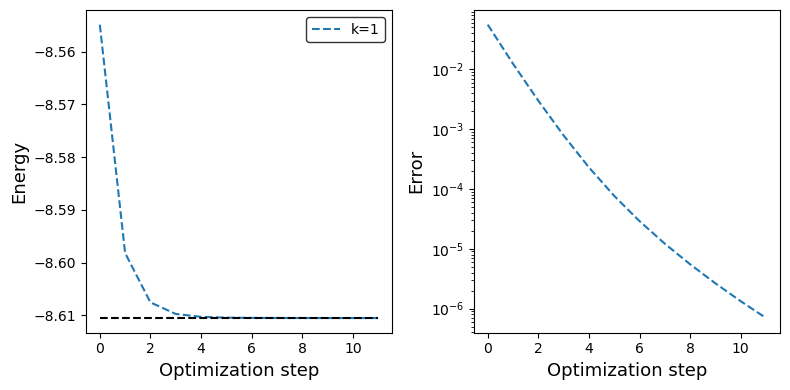

In [8]:
symbols = ["He", "He", "He"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 188.97259886, 0.0, 163.6528, 94.485], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=0)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

In [9]:
valores = []
for k in range(1):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 6,
        "qubits": molecule6.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=molecule6.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 15,
            "tol": 1e-6,
            "number": a*b,
            "theta":["generic", 0.3]}

    molecule6.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule6.cost_function)
    valores.append(energy1)

+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1


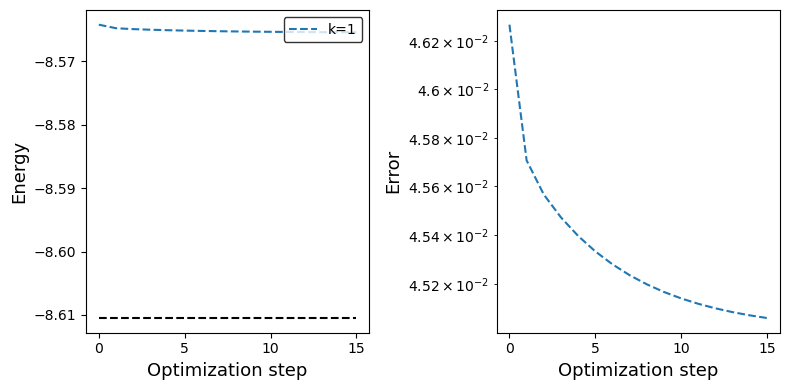

In [10]:
symbols = ["He", "He", "He"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 188.97259886, 0.0, 163.6528, 94.485], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=0)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()